Author: [Ahmed Yousri Sobhi](ahmedyousrisobhi@gmail.com)

Created_at: 4th Sep 2023

Notebook number: 1

Objective: Dataset Cleaning and Preprocessing

Abstract:
- After getting a gentle introduction with our dataset, Let's start cleaning and preprocessing the dataset.

# Importing Required Libararies and Packages

In [35]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np

# Used for visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

# For iteration visulization purpose
from tqdm import tqdm

# Create a report
from dataprep.eda import create_report

# Function Definitions

In [36]:
# Function to handle outliers
def remove_outlier_iqr(_df:pd.DataFrame, features_lst:list=None, target_col:str='')->pd.DataFrame:
    """
        Used to remove outliers based on input selected features in the dataframe.
        Outlier removal method is IQR

        PARAMETERS
            df: pandas DataFrame, describe input dataframe which require outliers removal
            features_lst: list, describe the input columns features list.
            target_col: str, describe the target column which we need to remove outlier from.

        RETURN
            Pandas DataFrame, after removing outliers
    """

    # Make a copy of input dataframe
    df_copy = _df.copy()

    if features_lst is not None:
        # Create empty list for records storing, to be converted into dataframe later.
        Q1 = df_copy.groupby(features_lst)[target_col].transform('quantile', 0.25)
        Q3 = df_copy.groupby(features_lst)[target_col].transform('quantile', 0.75)

    else:
        # Create empty list for records storing, to be converted into dataframe later.
        Q1 = df_copy[target_col].quantile(0.25)
        Q3 = df_copy[target_col].quantile(0.75)
        
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR

    upper_bound = Q3 + 1.5 * IQR

    return df_copy[df_copy[target_col].between(lower_bound, upper_bound, inclusive='both')]


def remove_outlier(df:pd.DataFrame, neglected_cols:list, dependant_cols:list)->pd.DataFrame:
    """
        Used to extract numerical columns and drop used input neglected columns,
        Then remove outliers from these columns based on selected dependant features
        using IQR

        PARAMETERS
            df: pandas DataFrame, user input dataframe.
            neglected_cols: list, numerical columns to drop and not interested in removing outliers for.
            dependant_cols: lst, columns to remove ouliters based on them.

        RETURN
            pandas DataFrame after removing outliers.    
    """

    # Create a copy of input dataset
    df_copy = df.copy()

    # Select numerical columns
    numeric_cols = df_copy.select_dtypes('number').columns.tolist()

    # Remove neglected columns
    for col in neglected_cols:
        if col in numeric_cols:
            numeric_cols.remove(col)    

    # Iterate over each numerical col and remove ouliers
    for col in tqdm(numeric_cols, total=len(numeric_cols)):

        # Using Iqr to remove outliers
        df_copy = remove_outlier_iqr(df_copy, dependant_cols, col)

    # It is a nesessary step to reset_index
    df_copy.reset_index(drop=True, inplace=True)

    return df_copy

# Function for Plotting
def plot_numeric_features(df:pd.DataFrame, cols_to_drop:list, plot_type, save_plot:bool, plot_name:str) -> None:
    """
        Used to plot numerical featuers based on input selected plot.

        Input:
            df: pandas DataFrame, input dataframe.
            cols_to_drop: list, list of columns to drop.
            plot_type: function, define the plot type.
            save_plot: boolean, to whether save plot or not.
            plot_name: str, name of the figure.

        Output:
            None
    """

    # Select Numerical columns only
    features_numeric = (
        df.drop(cols_to_drop, axis=1)
        .select_dtypes('number')
        .columns.tolist()
    )

    # Calculate the number of rows and columns for subplots
    num_rows = int(len(features_numeric) / 2) + len(features_numeric) % 2
    num_cols = 2

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

    # Iterate over features and plot distplot on subplots
    for i, feature in enumerate(features_numeric):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        plot_type(df[feature], ax=ax)
        ax.set_title(f'{plot_type.__name__} of {feature.capitalize()}')

    # Remove empty subplots if necessary
    if len(features_numeric) % 2 != 0:
        fig.delaxes(axes[num_rows - 1, num_cols - 1])

    # Set title for the whole plot
    fig.suptitle(f'{plot_type.__name__} Analysis', fontsize=16)
    plt.tight_layout()

    # Save the plot
    if save_plot == True:
        try:
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        except FileNotFoundError:
            print('Wring file or file path')
            print('Creating new directory')
            # Create required directories
            if not os.path.exists('../report/plots'):
                os.makedirs('../report/plots/')
            plt.savefig(f'../report/plots/{plot_name}_{plot_type.__name__}.jpg')
        
    plt.show()


# Data Loading

In [37]:
df = (
    pd.read_csv('../data/raw/marketing_campaign.csv', sep='\t')
    .assign(
        Dt_Customer= lambda x:pd.to_datetime(x.Dt_Customer, format='%d-%m-%Y')
    )
)

init_shape = df.shape

# Display first 5 rows
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


# Cleaning & Preprocessing
## Handling Missing Values

In [39]:
df.isna().sum()*100/df.shape[0]

ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 1.071429
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
dtype: float64

From the anlaysis did in the previous notebook "_1_data_raw_eda", we colnclude that, we can simply remove the records of the missing data of feature 'Income'.

In [40]:
# Drop the missing records
df.dropna(subset='Income', axis=0, inplace=True)

In [41]:
df.isna().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

## Handling Outliers
- From the previous analysis, it was shown that the following columns require handling the outliers to be removed.

In [42]:
outliers_cols= [
    'Income',
    'MntWines', 
    'MntFishProducts', 
    'MntSweetProducts', 
    'MntGoldProds', 
    "NumDealsPurchases", 
    "NumCatalogPurchases", 
    "NumWebVisitsMonth"
    ]

df[outliers_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.0,666666.0
MntWines,2216.0,305.091606,337.327920,0.0,24.0,174.5,505.0,1493.0
MntFishProducts,2216.0,37.637635,54.752082,0.0,3.0,12.0,50.0,259.0
MntSweetProducts,2216.0,27.028881,41.072046,0.0,1.0,8.0,33.0,262.0
MntGoldProds,2216.0,43.965253,51.815414,0.0,9.0,24.5,56.0,321.0
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.0,15.0
NumCatalogPurchases,2216.0,2.671029,2.926734,0.0,0.0,2.0,4.0,28.0
NumWebVisitsMonth,2216.0,5.319043,2.425359,0.0,3.0,6.0,7.0,20.0


In [43]:
# Calculate the records percentage of the outliers data in each feature
iqr = df[outliers_cols].quantile(0.75) - df[outliers_cols].quantile(0.25)
higher = df[outliers_cols].quantile(0.75) + iqr * 1.5

print("Percentage of outliers records:")
df_dict = {}
for col in outliers_cols:
    df_dict[col] = 100*df[df[col]> higher[col]].shape[0]/df.shape[0]

# Convert to dataframe
df_outlier_percentage = pd.DataFrame(df_dict.items() , columns=['feature', 'percentage'])

display(df_outlier_percentage)

Percentage of outliers records:


,feature,percentage
0,Income,0.361011
1,MntWines,1.579422
2,MntFishProducts,10.018051
3,MntSweetProducts,11.101083
4,MntGoldProds,9.250903
5,NumDealsPurchases,3.790614
6,NumCatalogPurchases,1.037906
7,NumWebVisitsMonth,0.361011


In [44]:
# Setting threshold of 3%
outlier_thr = 3

outliers_cols_selected = (
    df_outlier_percentage[df_outlier_percentage.percentage <= outlier_thr]
    ['feature'].tolist()
)

outliers_cols_selected

['Income', 'MntWines', 'NumCatalogPurchases', 'NumWebVisitsMonth']

In [45]:
cols_to_drop = list(set(df.columns.tolist()) - set(outliers_cols_selected))
dependant_cols = ['Marital_Status']
df = remove_outlier(df, cols_to_drop, dependant_cols)

100%|██████████| 4/4 [00:00<00:00, 358.98it/s]


In [46]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2143.0,5577.097993,3254.677178,0.0,2800.0,5453.0,8417.0,11191.0
Year_Birth,2143.0,1968.919739,11.927657,1893.0,1960.0,1970.0,1977.0,1996.0
Income,2143.0,51172.612692,20276.965107,4428.0,34951.0,50616.0,67269.5,113734.0
Kidhome,2143.0,0.451703,0.539197,0.0,0.0,0.0,1.0,2.0
Teenhome,2143.0,0.511433,0.543818,0.0,0.0,0.0,1.0,2.0
Recency,2143.0,49.010733,28.957975,0.0,24.0,49.0,74.0,99.0
MntWines,2143.0,286.915539,310.752015,0.0,23.0,170.0,483.0,1296.0
MntFruits,2143.0,26.161456,39.687941,0.0,2.0,8.0,32.0,199.0
MntMeatProducts,2143.0,159.041064,211.673063,0.0,15.0,64.0,217.0,984.0
MntFishProducts,2143.0,37.559029,55.148125,0.0,3.0,12.0,50.0,259.0


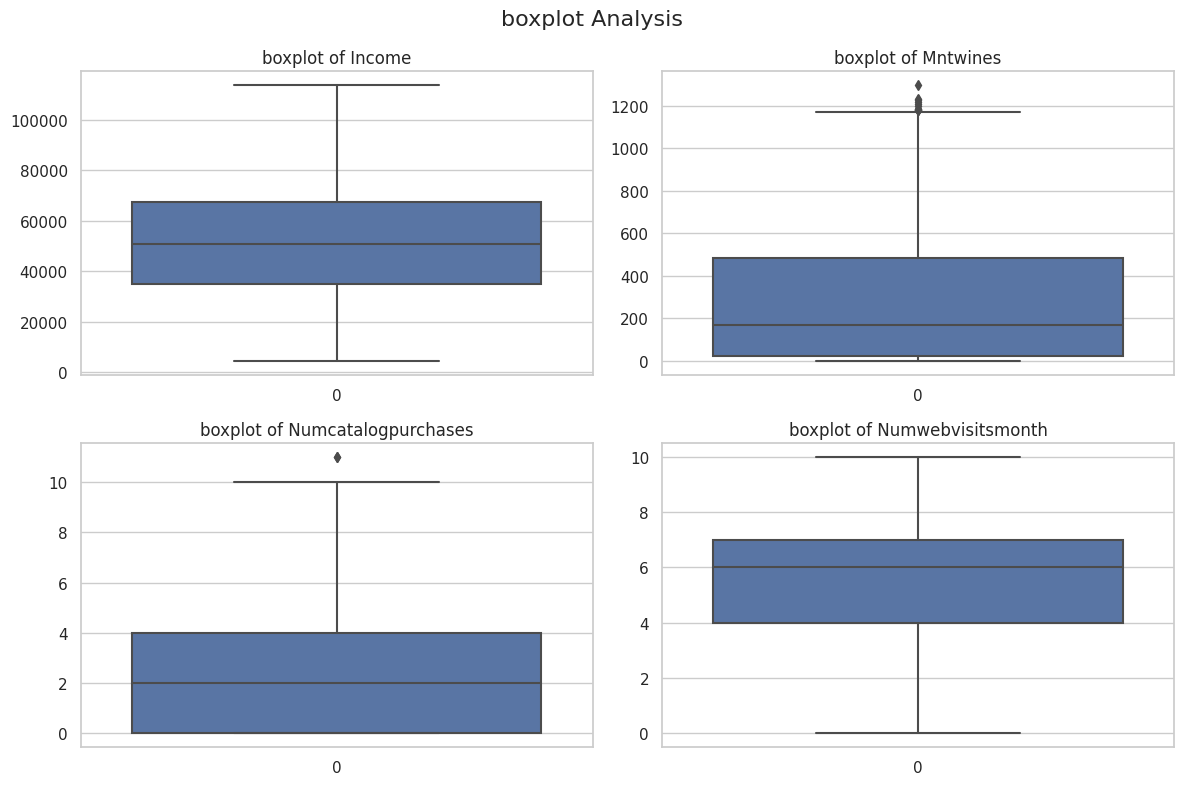

In [48]:
# Used to look at the distribution of a numerical variables
plot_numeric_features(df, cols_to_drop, sns.boxplot, save_plot=True, plot_name='data_after_remove_outliers')

# Create a Report

In [49]:
# Creating an analysis report regarding the dataset
report = create_report(df)
# Store the report in html format
try:
    report.save('../report/reports/cleaned_data_report')
except FileNotFoundError:
    print('Wring file or file path')
    print('Creating new directory')
    # Create required directories
    if not os.path.exists('../report/reports'):
        os.makedirs('../report/reports/')
    report.save('../report/reports/cleaned_data_report') 

  0%|          | 0/4287 [00:00<?, ?it/s]

Report has been saved to ../report/reports/cleaned_data_report.html!


# Save Cleaned Dataset Locally

In [50]:
df.to_csv('../data/intermid/marketing_campaign.csv', index=False)

In [51]:
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2139,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2140,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2141,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0
